https://github.com/mjpyeon/wavenet-classifier/blob/master/WaveNetClassifier.py

Dataset is the raw RADAR data that has not been reshaped into chirps.

## Notebook setup

Allow editing of modules using editor (auto reloading)

In [0]:
# Needed to allow editing using PyCharm etc
%load_ext autoreload
%autoreload 2

The following cell is needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [2]:
import os
path = os.getcwd()
if path == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif path == 'D:\\Google Drive\\Level-4-Project\\notebooks\\wavenet':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif path == "/export/home/2192793m":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/processed/wavenet/raw_reshaped/'
MODEL_PATH = BASE_PATH + 'models/wavenet/raw_reshaped/test_2/'
    
from src.data import load_data
from src.visualization import multiple_plots, visualize, plot_confusion_matrix
from src.features import make_spectrograms, process_labels, make_directory

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Obtaining file:///content/gdrive/My%20Drive/Level-4-Project
  Running setup.py develop for src


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Activation, Dropout, Add, TimeDistributed, Multiply, Conv1D, Conv2D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D
from keras.models import Model, Sequential, load_model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.callbacks import History, ModelCheckpoint
from keras.models import Sequential
import time

Using TensorFlow backend.


In [0]:
# Load in data dictionary.
# This does not load in any actual data,
# just the dictionary with the names of the files and their associated labels
with open(DATA_PATH + "index.pkl", "rb") as file:
    data = pickle.load(file)

In [0]:
# Remove user C as this user is reserved for the test set
try:
    del data["C"]
except KeyError:
    print ("Key 'C' not found")

In [0]:
def convert_label_to_int(label):
    if label == "walking":
        return 0
    if label == "pushing":
        return 1
    if label == "sitting":
        return 2
    if label == "pulling":
        return 3
    if label == "circling":
        return 4
    if label == "clapping":
        return 5
    if label == "bending":
        return 6

In [0]:
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
labels = {}
partition = {'train':[], 'validation':[]} # contains list of training and validation ID's
validation_user = "F"
for user_letter, actions in data.items():
    for action, results in actions.items():
        for result in results:
            for row in result:
                if user_letter == validation_user:
                    partition["validation"].append(row)
                    labels[row] = convert_label_to_int(action)

                else:
                    partition["train"].append(row)
                    labels[row] = convert_label_to_int(action)

In [0]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(3000), n_channels=1,
                 n_classes=7, shuffle=True, data_directory='data/'):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.data_directory = data_directory
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
#         start_time = time.time()

        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
#         time_for_getitem = (time.time() - start_time)
#         print(time_for_getitem)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
#         X = np.empty((self.batch_size, *self.dim))

        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample

#             X[i,] = np.expand_dims(abs(np.load(self.data_directory + ID)), axis=1)
            X[i,] = abs(np.load(self.data_directory + ID))
            # Store class
            y[i] = self.labels[ID]

        return X, to_categorical(y, num_classes=self.n_classes)

In [0]:
target_names = ["walking", "pushing", "sitting", "pulling", "circling", "clapping", "bending"]
nb_classes = len(target_names)

In [0]:
n_filters = 100
dilation_depth = 18
activation = 'softmax'
scale_ratio = 1
kernel_size = 2
pool_size_1 = 4
pool_size_2 = 8
batch_size = 4

In [0]:
# Parameters
params = {'dim': (3000,),
          'batch_size': batch_size,
          'n_classes': nb_classes,
          'n_channels': 128,
          'shuffle': True,
          'data_directory': DATA_PATH}
# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

In [0]:
# from https://github.com/mjpyeon/wavenet-classifier
class WaveNetClassifier():
    def __init__(self, input_shape, output_shape, kernel_size=2, dilation_depth=9, n_filters=40, pool_size_1=80, pool_size_2=100, load=False, load_dir='./'):
        """
        Parameters:
          input_shape: (tuple) tuple of input shape. (e.g. If input is 6s raw waveform with sampling rate = 16kHz, (96000,) is the input_shape)
          output_shape: (tuple)tuple of output shape. (e.g. If we want classify the signal into 100 classes, (100,) is the output_shape)
          kernel_size: (integer) kernel size of convolution operations in residual blocks
          dilation_depth: (integer) type total depth of residual blocks
          n_filters: (integer) # of filters of convolution operations in residual blocks
          load: (bool) load previous WaveNetClassifier or not
          load_dir: (string) the directory where the previous model exists
        """      
        self.activation = 'softmax'
        self.scale_ratio = 1      
        self.pool_size_1 = pool_size_1
        self.pool_size_2 = pool_size_2

        # save input info
        if len(input_shape) == 1:
            self.expand_dims = True
        elif len(input_shape) == 2:
            self.expand_dims = False
        else:
            print('ERROR: wrong input shape')
            sys.exit()
        self.input_shape = input_shape


        self.output_shape = output_shape

        # save hyperparameters of WaveNet
        self.kernel_size = kernel_size
        self.dilation_depth = dilation_depth
        self.n_filters = n_filters
        self.manual_loss = None


        if load is True:
            self.model = load_model(load_dir+"saved_wavenet_clasifier.h5", custom_objects={'tf':tf})
            self.prev_history = pd.read_csv(load_dir+'wavenet_classifier_training_history.csv')
            self.start_idx = len(self.prev_history)
            self.history = None
        else:
            self.model = self.construct_model()
            self.start_idx = 0
            self.history = None
            self.prev_history = None


    def residual_block(self, x, i):
        tanh_out = Conv1D(self.n_filters, 
                          self.kernel_size, 
                          dilation_rate = self.kernel_size**i, 
                          padding='causal', 
                          name='dilated_conv_%d_tanh' % (self.kernel_size ** i), 
                          activation='tanh'
                          )(x)
        sigm_out = Conv1D(self.n_filters, 
                          self.kernel_size, 
                          dilation_rate = self.kernel_size**i, 
                          padding='causal', 
                          name='dilated_conv_%d_sigm' % (self.kernel_size ** i), 
                          activation='sigmoid'
                          )(x)
        z = Multiply(name='gated_activation_%d' % (i))([tanh_out, sigm_out])
        skip = Conv1D(self.n_filters, 1, name='skip_%d'%(i))(z)
        res = Add(name='residual_block_%d' % (i))([skip, x])
        return res, skip

    def construct_model(self):    
        x = Input(shape=self.input_shape, name='original_input')
        if self.expand_dims == True:
            x_reshaped = Reshape(self.input_shape + (1,), name='reshaped_input')(x)
        else:
            x_reshaped = x
        skip_connections = []
        out = Conv1D(self.n_filters, 2, dilation_rate=1, padding='causal', name='dilated_conv_1')(x_reshaped)
        for i in range(1, self.dilation_depth + 1):
            out, skip = self.residual_block(out,i)
            skip_connections.append(skip)
        out = Add(name='skip_connections')(skip_connections)
        out = Activation('relu')(out)
        
        '''
        "For this task we added a mean-pooling layer after the dilated convolutions
        that agregated the activations to coarser frames spanning 10 milliseconds
        (160x downsampling). The pooling layer was followed by a few non-causal convolutions." - Wavenet Paper
        '''
        out = Conv1D(self.n_filters, self.pool_size_1, strides = 1, padding='same', name='conv_5ms', activation = 'relu')(out)
        out = AveragePooling1D(self.pool_size_1, padding='same', name='downsample_to_200Hz')(out)

        out = Conv1D(self.n_filters, self.pool_size_2, padding='same', activation='relu', name='conv_500ms')(out)
        out = Conv1D(self.output_shape[0], self.pool_size_2, padding='same', activation='relu', name='conv_500ms_target_shape')(out)
        out = AveragePooling1D(self.pool_size_2, padding='same',name = 'downsample_to_2Hz')(out)
        out = Conv1D(self.output_shape[0], (int) (self.input_shape[0]/(self.pool_size_1*self.pool_size_2)), padding='same', name='final_conv')(out)
        out = AveragePooling1D((int) (self.input_shape[0]/(self.pool_size_1*self.pool_size_2)), name='final_pooling')(out)
        out = Reshape(self.output_shape)(out)
        out = Activation(self.activation)(out)
        if self.scale_ratio != 1:
            out = Lambda(lambda x: x * self.scale_ratio, name='output_reshaped')(out)
        model = Model(x, out)  
        model.summary()
        return model

    def get_model(self):
        return self.model

    def add_loss(self, loss):
        self.manual_loss = loss

    def fit(self, X, Y, validation_data = None, epochs = 100, batch_size = 32, optimizer='adam', save=False, save_dir='./'):
        # set default losses if not defined
        if self.manual_loss is not None:
            loss = self.manual_loss
            metrics = None
        else:
            loss = 'categorical_crossentropy'
            metrics = ['accuracy']

        # set callback functions
        if save:
            saved = save_dir + "saved_wavenet_clasifier.h5"
            hist = save_dir + 'wavenet_classifier_training_history.csv'
            if validation_data is None:
                checkpointer = ModelCheckpoint(filepath=saved, monitor='loss', verbose=1, save_best_only=True)
            else:
                checkpointer = ModelCheckpoint(filepath=saved, monitor='val_loss', verbose=1, save_best_only=True)
            history = History()
            callbacks = [history, checkpointer]
        else:
            callbacks = None

        # compile the model
        self.model.compile(optimizer, loss, metrics)
        try:
            self.history = self.model.fit(X, Y, shuffle = True, batch_size=batch_size, epochs = epochs, validation_data = validation_data, callbacks=callbacks, initial_epoch=self.start_idx)
        except:
            if save:
                df = pd.DataFrame.from_dict(history.history)
                df.to_csv(hist, encoding='utf-8', index=False)
            raise
            sys.exit()
        return self.history


    def predict(self, x):
        return self.model.predict(x)

In [13]:
wnc = WaveNetClassifier((3000,128), (7,), kernel_size = kernel_size,
                        dilation_depth = dilation_depth, n_filters = n_filters,
                        pool_size_1=pool_size_1, pool_size_2=pool_size_2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
original_input (InputLayer)     (None, 3000, 128)    0                                            
__________________________________________________________________________________________________
dilated_conv_1 (Conv1D)         (None, 3000, 100)    25700       original_input[0][0]             
__________________________________________________________________________________________________
dilated_conv_2_tanh (Conv1D)    (None, 3000, 100)    20100       dilated_conv_1[0][0]             
__________________________________________________________________________________________________
dilated_conv_2_sigm (Conv1D)    (None, 3000, 100)    20100       dilated_conv_1[0][0]             
__________________________________________________________________________________________________
gated_acti

In [0]:
model = wnc.get_model()

In [0]:
load_weights = True
weights_path = MODEL_PATH + "epoch-33-val_acc-0.14.hdf5"

start_epoch = 0
if load_weights:
    model = load_model(weights_path)
#     model.load_weights(weights_path)
    last_epoch = weights_path.split("-")[-3]
    start_epoch = int(last_epoch)

In [0]:
if not load_weights:
    model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
checkpoint = ModelCheckpoint(MODEL_PATH + "epoch-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5",
                             monitor='val_acc', verbose=0, save_best_only=False,
                             save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint]

In [18]:
# Train model on dataset
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=9,
                    epochs=34,
                    callbacks=callbacks_list,
                    initial_epoch=start_epoch)

Epoch 34/34
725/726 [============================>.] - ETA: 1s - loss: 1.9446 - acc: 0.1528

726/726 [==============================] - 1268s 2s/step - loss: 1.9446 - acc: 0.1525 - val_loss: 1.9478 - val_acc: 0.1432


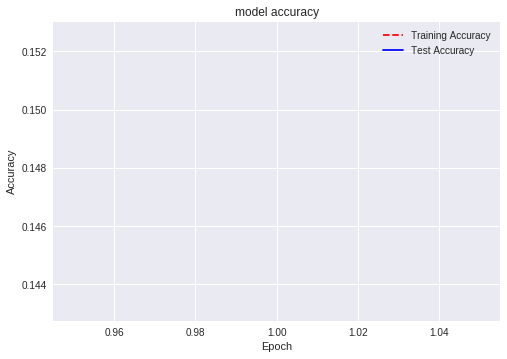

In [19]:
visualize.plot_train_test_acc(history=history)